This notebook addresses three main objectives:
1. First we generate synthetic data using the `DGen` module 
2. Second, we replicate the SCM from the `binaryClassification2.py` module
3. Finally, we test the results from step 2, using regular Logistic Regression (since the target is binary)

**Import Modules**

In [1]:
from  sklearn.datasets import make_regression
import pandas as pd    
import numpy as np
from DGen import DGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import importlib
import DGen
importlib.reload(DGen)

<module 'DGen' from 'C:\\Users\\kofi_\\Documents\\GitHub\\supervised-cadres\\notebooks\\DGen.py'>

In [3]:
# imports from binary example 2
import sys
from scipy.stats import zscore, zmap
from sklearn.model_selection import train_test_split, KFold
from itertools import product
from joblib import Parallel, delayed
from multiprocessing import cpu_count

In [4]:
sys.path.insert(0, '../cadreModels/')
from classificationBinary2 import binaryCadreModel

**Generate Cadres**

In [ ]:
c_samples = 1000
c_features = 10
c_informative = 5
c_cadres = 5
c_seed = 101

In [5]:
df_cadre = DGen.DGenerator.generate_cadres(samples = c_samples, features = c_features, informative = c_informative, cadres = c_cadres, seed = c_seed)
df_cadre.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,index_c
0,-0.269700,-0.052448,-0.491707,1.334820,0.346316,0.685278,-0.077507,0.936459,-0.135235,0.537657,0,0
1,-0.181931,0.649485,-0.422580,2.394812,-0.080366,2.889139,-0.699968,1.838718,1.496954,0.693969,0,1
2,-1.140108,-1.620099,-1.200107,1.817854,0.628411,0.961853,0.423366,-0.280959,0.051579,0.164921,0,2
3,-0.885340,-1.678986,0.836371,3.003209,1.146120,3.661416,0.646925,0.714126,3.296597,-1.059550,0,3
4,0.738830,1.005992,0.208713,0.909989,-1.547411,-0.346845,0.937485,1.302065,0.286691,-0.643863,0,4


**Generate Features and DVs**

In [ ]:
t_cadres = 5
t_samples = int(c_samples/t_cadres)
t_features = 5
t_classes = 2
t_informative = 3
t_seed = 101

In [6]:
df_variables = DGenerator.generate_variables(cadres = t_cadres, samples = t_samples, features = t_features, classes = t_classes, informative = t_informative, seed = t_seed)
df_variables.head()

,dv0,dv1,dv2,dv3,dv4,target,cadre,index_c
0,0.742269,0.831867,-0.771575,0.842334,0.520759,1,0,0
1,0.160512,-0.159833,-0.780318,0.409191,-0.527419,1,0,1
2,0.998435,-0.248226,-0.305384,-1.388785,-0.676256,0,0,2
3,-1.131430,1.655346,1.174063,2.429695,2.735830,0,0,3
4,-1.092046,0.077012,0.944960,0.616437,0.733610,0,0,4


In [7]:
z = pd.merge(df_cadre, df_variables)
z.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,index_c,dv0,dv1,dv2,dv3,dv4,target
0,-0.269700,-0.052448,-0.491707,1.334820,0.346316,0.685278,-0.077507,0.936459,-0.135235,0.537657,0,0,0.742269,0.831867,-0.771575,0.842334,0.520759,1
1,0.203320,1.429266,-2.340578,3.666363,0.666266,-0.237156,2.108665,2.719190,-0.814543,0.104569,0,0,0.742269,0.831867,-0.771575,0.842334,0.520759,1
2,-0.181931,0.649485,-0.422580,2.394812,-0.080366,2.889139,-0.699968,1.838718,1.496954,0.693969,0,1,0.160512,-0.159833,-0.780318,0.409191,-0.527419,1
3,-1.140108,-1.620099,-1.200107,1.817854,0.628411,0.961853,0.423366,-0.280959,0.051579,0.164921,0,2,0.998435,-0.248226,-0.305384,-1.388785,-0.676256,0
4,-0.885340,-1.678986,0.836371,3.003209,1.146120,3.661416,0.646925,0.714126,3.296597,-1.059550,0,3,-1.131430,1.655346,1.174063,2.429695,2.735830,0


**Begin SCM**

In [8]:
data = z.drop(['cadre','index_c'], 1)
data.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,dv0,dv1,dv2,dv3,dv4,target
0,-0.269700,-0.052448,-0.491707,1.334820,0.346316,0.685278,-0.077507,0.936459,-0.135235,0.537657,0.742269,0.831867,-0.771575,0.842334,0.520759,1
1,0.203320,1.429266,-2.340578,3.666363,0.666266,-0.237156,2.108665,2.719190,-0.814543,0.104569,0.742269,0.831867,-0.771575,0.842334,0.520759,1
2,-0.181931,0.649485,-0.422580,2.394812,-0.080366,2.889139,-0.699968,1.838718,1.496954,0.693969,0.160512,-0.159833,-0.780318,0.409191,-0.527419,1
3,-1.140108,-1.620099,-1.200107,1.817854,0.628411,0.961853,0.423366,-0.280959,0.051579,0.164921,0.998435,-0.248226,-0.305384,-1.388785,-0.676256,0
4,-0.885340,-1.678986,0.836371,3.003209,1.146120,3.661416,0.646925,0.714126,3.296597,-1.059550,-1.131430,1.655346,1.174063,2.429695,2.735830,0


Alex performs randomized train-test split

In [9]:
Dtr, Dva = train_test_split(data, test_size=0.2, random_state=101)

Separate cadre prediction features from target prediction features (optional)

In [10]:
cadreFts = data.columns[data.columns.str.contains('cad')]
predictFts = data.columns[data.columns.str.contains('dv')]

In [11]:
print(cadreFts)

Index(['cad0', 'cad1', 'cad2', 'cad3', 'cad4', 'cad5', 'cad6', 'cad7', 'cad8',
       'cad9'],
      dtype='object')


In [12]:
print(predictFts)

Index(['dv0', 'dv1', 'dv2', 'dv3', 'dv4'], dtype='object')


In [13]:
features = cadreFts.union(predictFts)

Standardize training and validation sets

In [14]:
Dva[features] = zmap(Dva[features].values, Dtr[features].values)
Dtr[features] = zscore(Dtr[features].values)

In [15]:
Dva.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,dv0,dv1,dv2,dv3,dv4,target
545,-2.154437,2.350941,0.817070,0.070597,0.183276,-1.197490,-0.388677,1.305508,0.306209,-1.129895,0.904040,0.438087,-0.494778,1.123486,0.954192,0
298,0.422691,-0.888574,0.652249,-2.150756,0.113665,0.704005,-0.669393,-1.346839,-0.103924,1.166866,1.164169,-0.802644,0.321042,1.299126,-1.566449,1
109,-1.709257,1.107386,-1.456361,1.621631,1.374521,-0.643293,-0.104316,1.352251,-1.119829,0.735789,1.186638,1.304159,0.714575,-0.935725,1.049344,1
837,0.716325,1.027042,0.235127,-0.269846,1.093935,0.525249,-0.917828,0.707867,-0.266655,1.145936,-0.965947,0.844382,1.147225,-0.895727,1.602720,1
194,1.068916,-1.909257,-0.176414,1.318712,-0.060179,1.498959,0.685068,-0.271883,0.637292,-0.087642,0.685876,1.218632,-0.443940,0.436173,0.786021,1


Define and train SCM model object. We're not going to tune any hyperparameters here. Note that we now supply the binaryCadreModel object with the cadre-assignment features and target-prediction features, as well as the name of the target feature.

If we did not supply any cadreFts or targetFts, they default to being every column in data other than targetCol

In [16]:
scm = binaryCadreModel(M=5, Tmax=1001, record=10)
scm.fit(data=Dtr,
       targetCol='target',
       cadreFts=cadreFts,
       predictFts=predictFts,
       dataVa=Dva,
       progress=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0
10 0.8208385 0.4775 0.7995537 0.555 0.2642242908477783
20 0.81429994 0.49625 0.79481584 0.55 0.9418368339538574
30 0.8107994 0.5 0.7922693 0.55 1.1147384643554688
40 0.80813026 0.50125 0.79016584 0.55 1.2876386642456055
50 0.8059521 0.50875 0.7884476 0.555 1.4725346565246582
60 0.80416214 0.5125 0.7869545 0.565 1.6494333744049072
70 0.80254394 0.52375 0.78550076 0.565 1.8323278427124023
80 0.8010125 0.52375 0.7841404 0.58 1.9992320537567139
90 0.79962647 0.52625 0.782937 0.58 2.1711337566375732
100 0.798263 0.53 0.781764 0.58 2.3480331897735596
110 0.7970829 0.54 0.7807642 0.585 2.527930498123169
120 0.79599094 0.54125 0.77980834 0.59 2.711825370788574
130 0.7949443 0.54875 0.77891356 0.59 2.8927218914031982
140 0.79380566 0.555 0.7779189 0.595 3.061626434326172
150 0.7927784 0.5575 0.77704 0.595 3.2375245094299316
160 0.7918765 0.5575 0.77629095 0.595 3.41142678260

The metrics attribute of scm contains training and validation metrics values. We can plot them separately. ROC_AUC is the receiver operator characteristic area under the curve (sklearn.metrics.roc_auc_score). PR_AUC is the average precision, i.e., area under the precision-recall curve (sklearn.metrics.average_precision_score).

The x-axis in these plots dependent on iteration count.

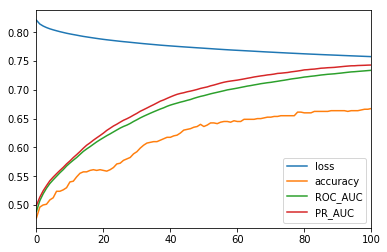

In [17]:
scm.metrics['training'].plot()

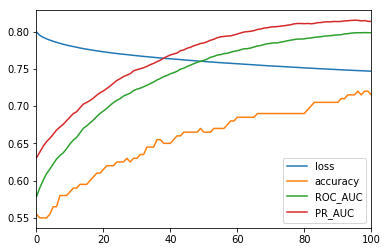

In [18]:
scm.metrics['validation'].plot()

Model parameters are stored as pd.DataFrame objects.

In [19]:
scm.W

,0,1,2,3,4
dv0,0.120721,0.093844,0.058915,-0.003124,-0.002593
dv1,-0.074982,-0.102949,-0.118991,-0.000026,0.000050
dv2,-0.002046,0.094000,0.180257,0.080697,0.217973
dv3,0.127287,-0.046809,-0.008243,-0.033597,-0.000005
dv4,0.208432,0.040007,-0.050242,0.053338,0.041541


In [20]:
scm.C

,0,1,2,3,4
cad0,-0.100156,0.084283,0.005360,0.048513,-0.081715
cad1,-0.114023,0.035790,-0.004804,0.109489,-0.037671
cad2,-0.100713,-0.045165,0.280118,0.169836,0.107118
cad3,0.260824,0.103698,-0.007322,0.068211,0.005900
cad4,-0.042863,-0.029358,-0.039610,-0.119269,-0.065141
cad5,0.077348,-0.076923,0.057591,0.071211,-0.077177
cad6,0.083113,0.028551,0.036153,0.098720,-0.051825
cad7,0.101556,-0.163074,0.094438,-0.011871,-0.184432
cad8,-0.025172,-0.066167,-0.037370,0.164598,0.074750
cad9,-0.046989,-0.141645,-0.051353,0.062336,0.048682


In [21]:
scm.proportions.head()

,0,1,2,3,4
0,0.21000,0.31375,0.18625,0.26750,0.02250
1,0.21875,0.30375,0.19250,0.25625,0.02875
2,0.22125,0.29875,0.20125,0.24750,0.03125
3,0.22625,0.29375,0.20625,0.24375,0.03000
4,0.22500,0.29125,0.21000,0.23750,0.03625


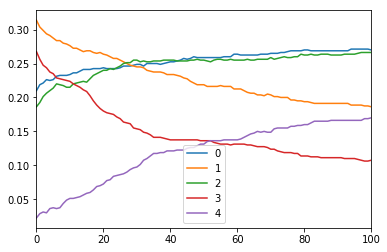

In [22]:
scm.proportions.plot()

Cadre 1 (orange) is the largest cadre and contains around 33% of the training data. Cadre 4 (purple) is the smallest. In Alex's code, one cadre disappears halfway through the training process

In [23]:
margin, label, cadre_weight, cadre, loss = scm.predictFull(Dva)

The predictFull method now also calculates the loss value for the supplied data as the last argument.

In [24]:
scm.scoreMetrics(Dva)

,loss,accuracy,ROC_AUC,PR_AUC
0,0.698886,0.715,0.798319,0.813482


**Logistic Regression**

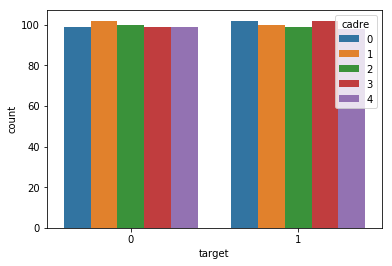

In [25]:
sns.countplot(x='target',data=z, hue='cadre')

Exploratory  - plot histogram to understand distribution of cadres with respect to target

Set up dataframe for X features and y features:
1. Note that we separate target prediction features from cadre prediction features
2. Due to the above, we perform a binomial logistic regression for the target using only the target prediction features (dv0 - dv4)
3. Then, we perform a multinomial logistic regression for the cadre assignment using only the cadre prediction features (cad0 - cad9)
4. We use the sklearn logistic regression model since the SCM does training and testing as well

In [27]:
# import Logistic Regression Module
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()

Logistic Regression for cadre 0

In [72]:
# select data for each cadre only

# Drop row/observation from dataset if cadre is not == 0
cadre0 = z[z.cadre == 0] 

# Select X features for cadre 0
cadre0X = cadre0.drop(['cadre', 'index_c', 'target','cad0','cad1','cad2','cad3','cad4','cad5','cad6','cad7','cad8','cad9'], axis=1) 

# Select y features for cadre 0
cadre0y = cadre0['target'] 

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(cadre0X, cadre0y, test_size=0.2, random_state=101)
cadre0_result = logreg.fit(X_train, y_train)

cadre0r = pd.DataFrame(cadre0_result.coef_)
cadre0r = cadre0r.T #need to transpose because results appear in array form

# rename index and colum for easy identification when merged
cadre0r.rename(index = {0: "dv0", 1: "dv1", 2: "dv2", 3: "dv3", 4: "dv4"}, inplace = True)
cadre0r.rename(columns = {0: "log0"}, inplace = True)

Logistic Regression for cadre 1

In [73]:
# Drop row/observation from dataset if cadre is not == 1
cadre1 = z[z.cadre == 1] 

# Select X features for cadre 1
cadre1X = cadre1.drop(['cadre', 'index_c', 'target','cad0','cad1','cad2','cad3','cad4','cad5','cad6','cad7','cad8','cad9'], axis=1) 

# Select y features for cadre 1
cadre1y = cadre1['target'] 

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(cadre1X, cadre1y, test_size=0.2, random_state=101)
cadre1_result = logreg.fit(X_train, y_train)

cadre1r = pd.DataFrame(cadre1_result.coef_)
cadre1r = cadre1r.T #need to transpose because results appear in array form

# rename index and colum for easy identification when merged
cadre1r.rename(index = {0: "dv0", 1: "dv1", 2: "dv2", 3: "dv3", 4: "dv4"}, inplace = True)
cadre1r.rename(columns = {0: "log1"}, inplace = True)

Logistic Regression for cadre 2

In [74]:
# Drop row/observation from dataset if cadre is not == 2
cadre2 = z[z.cadre == 2] 

# Select X features for cadre 2
cadre2X = cadre2.drop(['cadre', 'index_c', 'target','cad0','cad1','cad2','cad3','cad4','cad5','cad6','cad7','cad8','cad9'], axis=1) 

# Select y features for cadre 2
cadre2y = cadre2['target'] 

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(cadre2X, cadre2y, test_size=0.2, random_state=101)
cadre2_result = logreg.fit(X_train, y_train)

cadre2r = pd.DataFrame(cadre2_result.coef_)
cadre2r = cadre2r.T #need to transpose because results appear in array form

# rename index and colum for easy identification when merged
cadre2r.rename(index = {0: "dv0", 1: "dv1", 2: "dv2", 3: "dv3", 4: "dv4"}, inplace = True)
cadre2r.rename(columns = {0: "log2"}, inplace = True)

Logistic Regression for cadre 3

In [75]:
# Drop row/observation from dataset if cadre is not == 3
cadre3 = z[z.cadre == 3] 

# Select X features for cadre 3
cadre3X = cadre3.drop(['cadre', 'index_c', 'target','cad0','cad1','cad2','cad3','cad4','cad5','cad6','cad7','cad8','cad9'], axis=1) 

# Select y features for cadre 3
cadre3y = cadre3['target'] 

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(cadre3X, cadre3y, test_size=0.2, random_state=101)
cadre3_result = logreg.fit(X_train, y_train)

cadre3r = pd.DataFrame(cadre3_result.coef_)
cadre3r = cadre3r.T #need to transpose because results appear in array form

# rename index and colum for easy identification when merged
cadre3r.rename(index = {0: "dv0", 1: "dv1", 2: "dv2", 3: "dv3", 4: "dv4"}, inplace = True)
cadre3r.rename(columns = {0: "log3"}, inplace = True)

Logistic Regression for cadre 4

In [76]:
# Drop row/observation from dataset if cadre is not == 4
cadre4 = z[z.cadre == 4] 

# Select X features for cadre 4
cadre4X = cadre4.drop(['cadre', 'index_c', 'target','cad0','cad1','cad2','cad3','cad4','cad5','cad6','cad7','cad8','cad9'], axis=1) 

# Select y features for cadre 4
cadre4y = cadre4['target'] 

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(cadre4X, cadre4y, test_size=0.2, random_state=101)
cadre4_result = logreg.fit(X_train, y_train)

cadre4r = pd.DataFrame(cadre4_result.coef_)
cadre4r = cadre4r.T #need to transpose because results appear in array form

# rename index and colum for easy identification when merged
cadre4r.rename(index = {0: "dv0", 1: "dv1", 2: "dv2", 3: "dv3", 4: "dv4"}, inplace = True)
cadre4r.rename(columns = {0: "log4"}, inplace = True)

Next, we compare the results from the regular Logit regression with the SCM

In [70]:
# this is our result for running the SCM for our target
scm_target = pd.DataFrame(scm.W) 

# rename index and colum for easy identification when merged
scm_target.rename(columns = {0: "scm0", 1: "scm1", 2: "scm2", 3: "scm3", 4: "scm4"}, inplace = True)

scm_target 

,scm0,scm1,scm2,scm3,scm4
dv0,0.120721,0.093844,0.058915,-0.003124,-0.002593
dv1,-0.074982,-0.102949,-0.118991,-0.000026,0.000050
dv2,-0.002046,0.094000,0.180257,0.080697,0.217973
dv3,0.127287,-0.046809,-0.008243,-0.033597,-0.000005
dv4,0.208432,0.040007,-0.050242,0.053338,0.041541


In [71]:
# join scm coefficients to logistic regression results for individual cadres
compare_table = pd.concat([scm_target, cadre0r, cadre1r, cadre2r, cadre3r, cadre4r], axis = 1)
compare_table

,scm0,scm1,scm2,scm3,scm4,log0,log1,log2,log3,log4
dv0,0.120721,0.093844,0.058915,-0.003124,-0.002593,0.110749,-1.469676,0.454100,-1.635129,-0.459614
dv1,-0.074982,-0.102949,-0.118991,-0.000026,0.000050,0.197844,0.233465,-0.706790,-0.013470,-0.463613
dv2,-0.002046,0.094000,0.180257,0.080697,0.217973,-0.568977,0.976306,0.414327,0.923323,0.799459
dv3,0.127287,-0.046809,-0.008243,-0.033597,-0.000005,0.706340,2.339101,0.110600,-0.366505,-1.096094
dv4,0.208432,0.040007,-0.050242,0.053338,0.041541,-0.003251,0.753641,-0.047166,-0.167681,0.850943


The table above compares the coefficients from teh SMC and Logit Regression. NB: Not sure what to make of this yet. Need more searching 